In [ ]:
%load_ext autoreload
%autoreload 2

#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataSciece.changeDirOnImportExport setting
import os
try:
    os.chdir(r'C:\Users\kevin\Documents\Workspace\psylit-experiments')
    print("Changed cwd:", os.getcwd())
except:
    print("cwd:", os.getcwd())

from collections import Counter, defaultdict
from statistics import mean
from os import linesep as EOL
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['figure.figsize'] = 16,10
np.random.seed(0)


In [ ]:
from itertools import islice

In [ ]:
from tic import preprocess

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')   # 'Vanilla' spacy model: spacy.load('en_core_web_sm')

merge_ents = nlp.create_pipe("merge_entities")

nlp.add_pipe(merge_ents, after="ner")

from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

In [ ]:
import time

def maybe(f, default=None):
    try:
        return f()
    except:
        return default

class show_progress:
    
    def __init__(self, seq, fmt_progress="{i} / {n}", fmt_time=(" "*4+"{t:.5f}s")):
        self.n = maybe(lambda: len(seq))
        self.seq = iter(seq)
        self.i = 0
        self.fmt_progress = fmt_progress
        self.fmt_time = fmt_time
        self.t = time.perf_counter()
    
    def __iter__(self):
        #print(self.fmt_progress.format(i=self.i, n=self.n))
        #self.t = time.perf_counter()
        return self
    
    def __next__(self):
        self.t = time.perf_counter() - self.t
        if self.i:
            print(self.fmt_time.format(t=self.t))
        self.i += 1
        if self.n and self.i <= self.n:
            print(self.fmt_progress.format(i=self.i, n=self.n))
        if not self.n:
            print(self.i)
        self.t = time.perf_counter()
        return next(self.seq)
        
        
def human_print_dict(d, tab=' '*2, level=0):
    for k, v in d.items():
        print(f"{tab*level}{k}:", end=' ')
        if type(v) == dict:
            print(tab*level)
            human_print_dict(v, tab, level+1)
        else:
            print(v)

In [ ]:
FUNCTIONAL_DEPS = ('det','poss','neg','aux','auxpass','ps','mark','ccomp','xcomp','acomp','prt') # TODO spacy equiv of ps

def deppaths(doc, skip=(lambda t: t.is_space or t.is_punct), include=(lambda t: not t.is_stop)):

    def deppaths_sent(sent):
        prev_path_ids = None
        for tok in sent:
            if tok.n_lefts or tok.n_rights:
                continue
                
            path = [tok] + list(tok.ancestors)
            path = list(filter(include, path))
            if not path:
                continue

            yield path

    for sent in doc.sents:
        sent = (t for t in sent if not skip(t))
        paths = list(deppaths_sent(sent))
        
        # paths are uniquely identified in the sent by their leaf token
        # the last one for a given id is the the complete one
        # assumes dicts are ordered (Py 3.6+)
        
        paths = {p[-1]: p for p in paths}
        yield from paths.values()
        
def is_infinitive_verb(token, lemmatizer):
    return t.pos_ == 'VERB' and t.text in lemmatizer(t.text, t.pos)
                
def format_paths(grams, 
                 # split_cond: lambda t: is_prep(t)
                 merge_cond=(lambda t: t.dep_ in ('neg','prt') or is_infinitive_verb(token, lemmatizer)), 
                 process=(lambda t: t.lemma_ if t.pos_ in ('VERB','NOUN') else t.text), 
                 join='-'.join): # merge might include preps
    for gram in grams:
        n = len(gram)
        gram_toks = []
        suffixes = []
        for t in reversed(gram):
            txt = process(t)
            if merge_cond(t):
                suffixes.insert(0, txt)
            else:
                tok_txt = join([txt] + suffixes)
                gram_toks.append(tok_txt)
                suffixes = []
                
        yield gram_toks

def ngrams_from_paths(paths):
    paths = list(paths)
    for p in paths:
        agent, predicate, arguments = None, None, {}
        pos = [t.pos_ for t in p]
        dep = [t.dep_ for t in p]
        agent_i = dep.find('nsubj')
        if agent_i:
            agent = p[agent_i]
            p = p[:agent_i] + (p[agent_i+1:] if agent_i <= len(p) else [])
        
        
        

In [ ]:
        
class Grams(Sequence):
    
    def __init__(self, grams):
        """
        grams: Seq[Iterable]
        """
        self.grams = grams
    
    def map(self, f):
        self.grams = map(f, self.grams)
    
    def merge_from_right(self, match):
        def process():
            for gram in self.grams:
                suffixes = []
                for t in reversed(gram):
                    if match(t):
                        suffixes.insert(0, t)
                    else:
                        yield [t] + suffixes
                        suffixes = []
        
        return DisjointGrams(process())
        
        
class DisjointGrams(Sequence):
    
    def __init__(self, grams):
        """
        grams: Seq[Iterable[Iterable]]
        """
        self.grams = grams

    def join(self, join):
        return Grams(join(g) for g in self.grams)
    
def ngrams_from_paths(paths, n=2, is_counted=(lambda t: t.dep_ not in FUNCTIONAL_DEPS), step=1):
    for p in paths:
        yield from ngrams_from_words(p, n, is_counted, step)

def ngrams_from_words(toks, n=2, is_counted=(lambda t: t.dep_ not in FUNCTIONAL_DEPS), step=1):
    content_idx = [i for i,t in enumerate(toks) if is_counted(t)]
    m = len(content_idx)
    for j in range(n, m, step):
        gram_slice = slice(content_idx[j - n], content_idx[j])
        yield toks[gram_slice]

In [ ]:

class process_rgrams:
    
    def __init__(self, doc, nmax=3):
        all_words = list(doc)
        words = [t for t in all_words if (not t.is_space) and (not t.is_punct) and (not t.is_stop)]
        self.reg_grams = [
            list(format_rgrams(ngrams_from_words(words, n)))
            for n in range(1, nmax+1)
        ]
        self.nmax = nmax
        self.reg_grams_count = [Counter(map(tuple, gs)) for gs in self.reg_grams]

        self.stats = {}
        
    def summary(self):
        sm = {}
        for n in range(self.nmax):
            sm[f'n_reg_{n+1}grams'] = len(self.reg_grams_count[n])
        return {**self.stats, **sm}

class process_frames:
    def __init__(self, doc, nmax=3):
        all_words = list(doc)
        words = [t for t in all_words if (not t.is_space) and (not t.is_punct) and (not t.is_stop)]
        paths = list(deppaths(doc))
        self.syn_grams = [
            list(format_paths(ngrams_from_paths(paths, n)))
            for n in range(1, nmax+1)
        ]
        self.syn_grams_count = [Counter(map(tuple, gs)) for gs in self.syn_grams]
        self.nmax = nmax

        self.stats = {
            'n_dep_paths': len(paths),
            'avg_path_length': mean(len(p) for p in paths),
        }
        
    def summary(self):
        sm = {}
        for n in range(self.nmax):
            sm[f'n_syn_{n+1}grams'] = len(self.syn_grams_count[n])
        return {**self.stats, **sm}
    
class process_doc:
    
    def __init__(self, doc, nmax=3):
        all_words = list(doc)
        all_sents = list(doc.sents)
        ng = process_rgrams(doc, nmax)
        sng = process_sngrams(doc, nmax)
        self.syn_grams_count = sng.syn_grams_count
        self.reg_grams_count = ng.reg_grams_count
        
        self.stats = {
            'n_tokens': len(all_words),
            'avg_sentence_length': mean(len(s) for s in all_sents),
            'n_sentences': len(all_sents),
            **ng.summary(),
            **sng.summary(),
        }
        
    def summary(self):
        return self.stats
    
class process_corpus:
    
    def __init__(self, texts, batch_size=8, disable=None, nmax=3, **kwargs):
        disable = disable or []
        self.reg_grams_count = [Counter() for _ in range(nmax)]
        self.syn_grams_count = [Counter() for _ in range(nmax)]
        self.summaries = []
        self.suspicious_docs = []
        pipeline = nlp.pipe(texts, batch_size=batch_size, disable=disable)
        #pipeline = (nlp(txt, disable=disable) for txt in texts)
        for doc in show_progress(pipeline):
            d = process_doc(doc, **kwargs)
            self.summaries.append(d.summary())
            
            if len(set(t.text for t in d.reg_grams_count[2].keys())) == 1:
                self.suspicious_docs.append(doc)
            if len(set(t.text for t in d.syn_grams_count[2].keys())) == 1:
                self.suspicious_docs.append(doc)
            for n in range(nmax):
                
                self.reg_grams_count[n] += d.reg_grams_count[n]
                self.syn_grams_count[n] += d.syn_grams_count[n]
        
        self.summary = pd.DataFrame(self.summaries)
        del self.summaries

In [ ]:
data_root = r'..\datasets\2_txtalb_Novel450'
files = [os.path.join(data_root, f) for f in os.listdir(data_root) if f.startswith('EN_')][60:70]#110]
nfiles = len(files)

In [ ]:
corpus = process_corpus(preprocess.read_pg(filename)[:nlp.max_length] for filename in files)

In [ ]:
corpus.summary.describe()

In [ ]:
corpus.syn_grams_count[2].most_common(50)

In [ ]:
data_root = r'..\datasets\2_txtalb_Novel450'
files = [os.path.join(data_root, f) for f in os.listdir(data_root) if f.startswith('EN_')][60:110]
        
def all_ngrams(files):
    texts = (preprocess.read_pg(filename)[:nlp.max_length] for filename in files)
    counter = Counter()
    disabled = ['tagger','parser','ner','entity_ruler','sentencizer','merge_entities']
    for doc in [nlp(txt, disable=disabled) for txt in texts]:#(nlp.pipe(texts, batch_size=2, disable=disabled)):
        c = process_rgrams(doc)
        counter += c.reg_grams_count[2]
    return counter

c = all_ngrams(files)
c.most_common(50)

In [ ]:
[x[:20] for x in (preprocess.read_pg(filename)[:nlp.max_length] for filename in files)]

In [ ]:
dep_cnt = Counter(t.dep_ for t in doc)
dep_cnt

In [ ]:
content_dep_cnt = Counter(t.dep_ for t in doc if t.dep_ not in FUNCTIONAL_DEPS)
sum(content_dep_cnt.values()), sum((dep_cnt - content_dep_cnt).values()), sum((dep_cnt).values())

In [ ]:
from itertools import islice

sents = {}
current_sent_start = None
for gram in islice(grams, 50):
    sent = gram[0].sent
    if sent.start != current_sent_start:
        current_sent_start = sent.start
        print(current_sent_start, " ".join(t.text for t in sent if not t.is_space))
        sents[current_sent_start] = sent
    gram_pos = [t.pos_ for t in gram]
    gram_dep = [t.dep_ for t in gram]
    print(gram)
    print(" "*6, gram_dep)
    print(" "*6, gram_pos)

In [ ]:
from spacy import displacy
displacy.render(sents[3], style="dep")

In [ ]:
"The family of Dashwood had long been settled in Sussex ."
['settle', 'family', 'of', 'Dashwood']
['settle', 'in', 'Sussex']

In [ ]:
list(sents[3][7].ancestors), sents[3][7].dep_
list(sents[3][3].ancestors), sents[3][7].dep_

In [ ]:
list(sents[3].root.subtree)

In [ ]:
def ancestors(tok):
    while tok.head != tok:
        tok = tok.head
        yield tok
    if tok.head != tok:
        yield tok

print("--- custom:")
for t in sents[3]:
    print(list(ancestors(t))[::-1], t.dep_, t)

print("--- spacy:")
for t in sents[3]:
    print(list(t.ancestors)[::-1], t.dep_, t)

In [ ]:
displacy.render(nlp("He didn't even look at her."), style="dep")

In [ ]:
a = []
a.insert(0, 42)
a.insert(0, 43)
a

In [ ]:
help(list)

In [ ]:
help(range)

In [ ]:
list(range(2,8))

In [ ]:
sents = list(doc.sents)

In [ ]:
list(sents[1])

In [ ]:
help(set)

In [ ]:
help(slice)

In [ ]:
[(t.text, t.dep_, t.pos_) for t in nlp('Alice was going up the stairs.')]

In [ ]:
x = 4
for i in range(2, x):
    print(i)
else:
    print('empty')

In [ ]:
[f for f in os.listdir(r'..\datasets\2_txtalb_Novel450') if f.startswith('EN_')]

In [ ]:
len([f for f in os.listdir(r'..\datasets\2_txtalb_Novel450') if f.startswith('EN_')])

In [ ]:
"{:.6f}s".format(time.perf_counter() - time.perf_counter())

In [ ]:
a = time.perf_counter()

In [ ]:
help(nlp.pipe)

In [ ]:
help(doc)

In [ ]:
{k for k in globals().keys() if not k.startswith('_')}

In [ ]:
class Toto:pass

t = Toto()
t.a = 42
t2 = Toto()
try:
    print(t.a, t2.a)
except Exception as e:
    print(e)
t2.a = 43
print(t.a, t2.a)

In [ ]:
x=np.triu(np.random.random([6,6])*2-1)
x-x.T*(1+np.random.random([6,6])*.2-.1)

In [ ]:
import networkx

In [ ]:
d=nlp("Bob invited Alice for a tea at his place. Alice wasn't feeling sad anymore")

In [ ]:
df=pd.DataFrame({'text':t.text, 'dep':t.dep_, 'pos':t.pos_, 'lemma':t.lemma_, 'stop':t.is_stop} for t in d)
df

In [ ]:
import flair

In [ ]:
from flair.embeddings import FlairEmbeddings, BertEmbeddings

# init Flair embeddings
#flair_forward_embedding = FlairEmbeddings('multi-forward')
#flair_backward_embedding = FlairEmbeddings('multi-backward')

# init multilingual BERT
bert_embedding = BertEmbeddings('bert-base-cased')

In [ ]:
from flair.embeddings import StackedEmbeddings

# now create the StackedEmbedding object that combines all embeddings
stacked_embeddings = StackedEmbeddings(
    embeddings=[
        #flair_forward_embedding,
        #flair_backward_embedding,
        bert_embedding])

In [ ]:
import nltk
nltk.download('framenet_v17')

In [ ]:
from nltk.corpus import framenet as fn
len(fn.frames())

In [539]:
txt=preprocess.read_pg(data_root + r'\EN_1818_Shelley,Mary_Frankenstein_Novel.txt')
print(len(txt), 'chars')

from segtok.segmenter import split_single
sentences = [Sentence(s, use_tokenizer=True) for s in split_single(txt)]
print(len(sentences), 'sentences')

423211 chars
3400 sentences


In [438]:
import random as rand

t = range(100)#rand.sample(range(len(sentences)), 100)
sents_sample = [sentences[i] for i in sorted(t)]

t = np.array(t)
_ = bert_embedding.embed(sents_sample)

In [455]:
from scipy.spatial.distance import cosine
from torch.nn.functional import cosine_similarity
from itertools import product

def cosines(tokens):
    s = np.zeros([n,n])
    for (i, j), _ in np.ndenumerate(s):
        s[i, j] = cosine(tokens[i], tokens[j])
    return s

def cosines(vecs, return_type=np.zeros):
    vecs = list(vecs)
    n = len(vecs)
    c = return_type([n,n])
    # TODO compute all norms at once
    for i in range(n):
        vi = vecs[i]
        vi2 = th.norm(vi)
        for j in range(i, n):
            vj = vecs[j]
            vj2 = th.norm(vj)
            c[j, i] = c[i, j] = 1 - th.dot(vi, vj) / (vi2 * vj2)  #cosine(vecs[i], vecs[j])
    return c

In [488]:
toks = [t for s in sents_sample for t in s]
toks_str = np.array([t.text for t in toks])

In [456]:
D = cosines(t.embedding.numpy() for t in toks)

In [ ]:
toks_str[0]

In [457]:
beta = 0.1
S = np.exp(-beta * D / D.std())

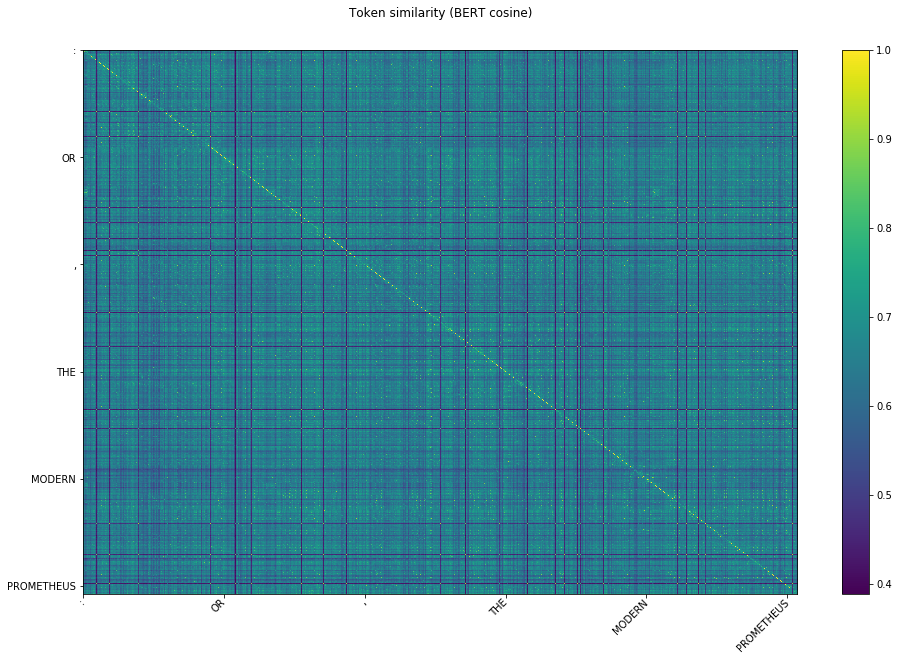

In [489]:
fig = plt.figure()
ax = plt.gca()
im = ax.matshow(S,aspect='auto')
fig.colorbar(im)
ax.set_xticklabels(toks_str)
ax.set_yticklabels(toks_str)
# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
ax.set_title("Token similarity (BERT cosine)")
#fig.tight_layout()
plt.show()

fraction > 0: 0.5001971608832808


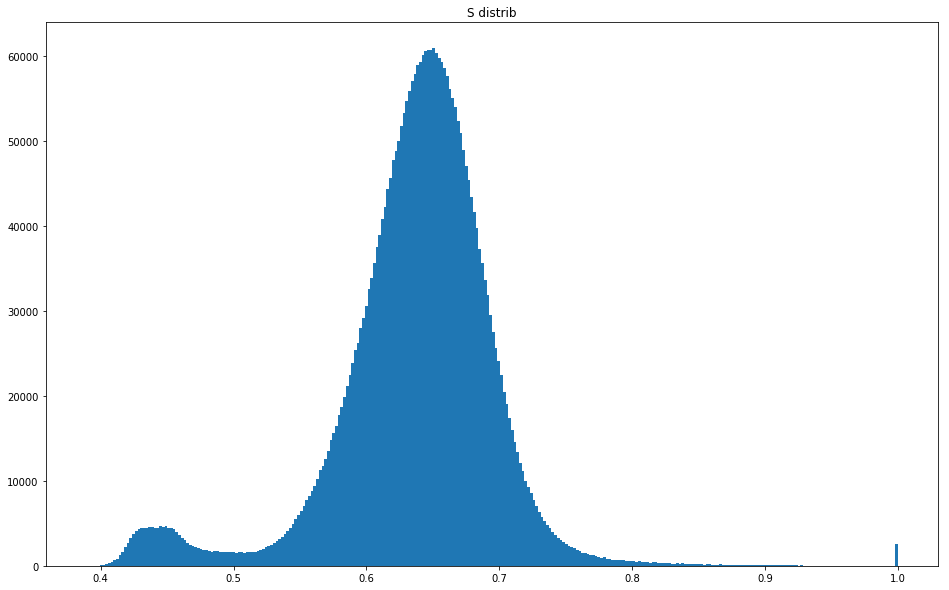

In [459]:
dist = np.triu(S).flatten()
dist_plus = dist[dist > 0]
print('fraction > 0:',len(dist_plus) / len(dist))
plt.hist(dist_plus, bins=300)
plt.title('S distrib')
plt.show()

In [598]:
thres = np.mean(dist) + 1*np.std(dist)
thres

0.6398105902428406

In [ ]:
STOPS = set(t.text for t in nlp.vocab if t.is_stop)

In [599]:
S_flat = np.triu(S - np.eye(S.shape[0])).flatten()
highest_i_flat = np.argwhere(S_flat > thres).flatten()
highest_i = np.array(np.unravel_index(highest_i_flat, S.shape))
highest_i

array([[   0,    0,    0, ..., 2532, 2532, 2533],
       [   1,    2,    3, ..., 2533, 2534, 2534]], dtype=int64)

In [600]:
S_highest = S[highest_i[0,:],highest_i[1,:]]

In [522]:
most_similars_str = toks_str[highest_i]
df = pd.DataFrame({'t0':most_similars_str[0,:], 't1':most_similars_str[1,:], 'similarity':S_highest})
df = df[~df.t0.isin(STOPS) & ~df.t1.isin(STOPS) ]
df

,t0,t1,similarity
0,FRANKENSTEIN,:,0.676069
1,FRANKENSTEIN,OR,0.658996
2,FRANKENSTEIN,",",0.665874
3,FRANKENSTEIN,THE,0.694360
4,FRANKENSTEIN,MODERN,0.762151
5,FRANKENSTEIN,PROMETHEUS,0.741227
6,FRANKENSTEIN,.,0.692842
7,FRANKENSTEIN,BY,0.705134
8,FRANKENSTEIN,MARY,0.753172
9,FRANKENSTEIN,W,0.693343


In [523]:
ner_like = df.t0[~df.t0.isin(STOPS)
                 & ~df.t0.str.isupper() 
                 & df.t0.str.get(0).str.isupper()
                ].value_counts()
ner_like[ner_like > 1]

The            15580
These           6085
Petersburgh     3627
This            3211
Paradise        2928
Shakspeare      2927
Margaret        2913
But             2653
My              2456
Dr.             2152
Darwin          2151
Germany         2142
St.             2126
Iliad           2006
Greece          2000
Tempest         1994
Midsummer       1991
Night           1990
Dream           1989
To              1989
Mrs.            1987
Saville         1985
Milton          1984
England         1981
Lost            1980
North           1910
Other           1891
Geneva          1728
German          1704
Two             1681
               ...  
September       1591
Dec.            1568
London          1512
Inspirited      1457
Its             1342
Thomas          1189
Pacific         1060
Ocean           1059
Archangel        983
If               945
Homer            931
Six              891
Sea              848
Twice            791
Greenland        783
And              742
Oh           

In [518]:
alltoks = set(toks_str)
alltoks

{'!',
 "'s",
 '(',
 ')',
 ',',
 ',—',
 '.',
 '11th',
 '17',
 '1816',
 '1817',
 '28th',
 ':',
 ';',
 '?',
 'Ah',
 'Alps',
 'And',
 'Archangel',
 'At',
 'BY',
 'But',
 'Darwin',
 'Dec.',
 'Do',
 'Dr.',
 'Dream',
 'England',
 'English',
 'FRANKENSTEIN',
 'Farewell',
 'Geneva',
 'German',
 'Germany',
 'Greece',
 'Greenland',
 'Heaven',
 'Homer',
 'How',
 'I',
 'II',
 'If',
 'Iliad',
 'Inspirited',
 'It',
 'Its',
 'June',
 'LETTER',
 'London',
 'Lost',
 'MARY',
 'MODERN',
 'March',
 'Margaret',
 'Marlow',
 'Midsummer',
 'Milton',
 'Mrs.',
 'My',
 'Night',
 'North',
 'Now',
 'OR',
 'Ocean',
 'Oh',
 'Other',
 'PREFACE',
 'PROMETHEUS',
 'Pacific',
 'Paradise',
 'Petersburgh',
 'R.',
 'Russia',
 'SHELLEY',
 'Saville',
 'Sea',
 'September',
 'Shakspeare',
 'Six',
 'St.',
 'THE',
 'Tempest',
 'The',
 'There',
 'These',
 'They',
 'This',
 'Thomas',
 'To',
 'Twice',
 'Two',
 'W',
 'Walton',
 'Well',
 'What',
 'Yet',
 'You',
 'Your',
 'a',
 'able',
 'about',
 'absence',
 'acceptable',
 'accompanied'

In [524]:
def querydf(df, included=None, excluded=None):
    included = included if included is not None else ~df.t0.isnull()
    excluded = excluded if excluded is not None else df.t0.isnull()
    d = df[(df.t0 != df.t1) & included & ~excluded]
    return d.groupby(['t0','t1']).mean().sort_values('similarity', ascending=False)

In [531]:
querydf(df,
       included = (df.t0 == 'me') & df.t1.str.get(0).str.islower(),
       )
        #excluded = df.t1.isin({'Miss','Mrs.','ladies','lady','girl','girls','her'}))

similarity
t0 t1                      
me my              0.786178
   myself          0.779327
   mine            0.772525
   lived           0.725303
   journey         0.719162
   commence        0.718646
   mankind         0.717292
   travelling      0.713044
   body            0.712389
   ardour          0.710974
   scenes          0.710912
   undoubtedly     0.710673
   try             0.710073
   discovering     0.709876
   letter          0.709446
   man             0.709263
   great           0.708240
   discover        0.707806
   curiosity       0.707402
   often           0.706582
   passionately    0.706464
   become          0.706341
   obtain          0.706229
   remain          0.705354
   imagined        0.704729
   reflections     0.704392
   greatly         0.703821
   voluntarily     0.703125
   glowing         0.702852
   our             0.701782
...                     ...
   difference      0.616652
   if              0.615905
   veins           0.615708
   since           0.614707
   without         0.611693
   dying           0.609365
   again           0.609350
   forebodings     0.609058
   fortnight       0.608505
   down            0.608085
   habitable       0.605290
   branches        0.604134
   despise         0.603660
   surpassing      0.602531
   much            0.601933
   from            0.601257
   or              0.600656
   so              0.597165
   as              0.597051
   elevates        0.596952
   at              0.595348
   before          0.590193
   perhaps         0.589250
   night           0.584182
   hitherto        0.579290
   only            0.576970
   enough          0.572169
   pass            0.571577
   call            0.553959
   three           0.545417

[618 rows x 1 columns]

In [ ]:
lady_bow = {'Miss','Mrs.','ladies','lady','girl','girls','her'}
included = df.t1.isin(lady_bow) & df.t0.str.get(0).str.isupper()
excluded = df.t0.isin(lady_bow)
df[(df.t0 != df.t1) & included & ~excluded].groupby(['t0','t1']).mean().sort_values('similarity', ascending=False)

In [ ]:
included = (df.t0 == 'Emma') & df.t1.str.get(0).str.islower()
excluded = df.t1.isin({'Miss','Mrs.','ladies','lady','girl','girls','her'})
emma = df[(df.t0 != df.t1) & included & ~excluded]
emma.groupby(['t0','t1']).mean().sort_values('similarity', ascending=False)

In [ ]:
df[(df.t0 == 'Agatha') & (df.t1 == 'Emma')].plot()

In [410]:
tdf = pd.DataFrame({'tok':toks_str})

In [418]:
counts = tdf.tok[~tdf.tok.isin(STOPS) & tdf.tok.str.get(0).str.isupper()].value_counts()
counts[counts > 1]
#tdf[tdf.tok == 'mourning']

Agatha         27
Major          14
Harper         12
Mrs.           12
Bowen           9
Miss            9
Thornycroft     7
Ianson          6
Hill            5
And             5
Now             3
Oh              3
Then            3
But             3
The             3
However         2
Canada          2
These           2
Emma            2
Dr.             2
If              2
In              2
No              2
A               2
Mr.             2
Name: tok, dtype: int64

In [534]:
def trajectories(toks, ref_tok, traj_toks):
    toks_str = np.array([t.text for t in toks])
    ref_vecs = [t.embedding for t in toks if t.text == ref_tok]
    print(len(ref_vecs), 'vecs for', ref_tok)
    ref_vec = th.mean(th.stack(ref_vecs), dim=0)
    trajs = []
    for tok in traj_toks:
        vecs = [t.embedding for t in toks if t.text == tok]
        print(len(vecs), 'vecs for', tok)
        #diffs = np.array([(v - ref_vec).numpy() for v in vecs])
        #sims = np.linalg.norm(diffs, axis=1)
        sims = np.array([cosine(v.numpy(), ref_vec.numpy()) for v in vecs])
        trajs.append(sims)
    return trajs

def plot_trajs(toks, ref_tok, traj_toks):
    trajs = trajectories(toks, ref_tok, traj_toks)
    for traj in trajs:
        plt.plot(traj)
    plt.title(f"Distance to '{ref_tok}'")
    plt.legend(traj_toks)

2 vecs for enthusiasm
17 vecs for me
7 vecs for you


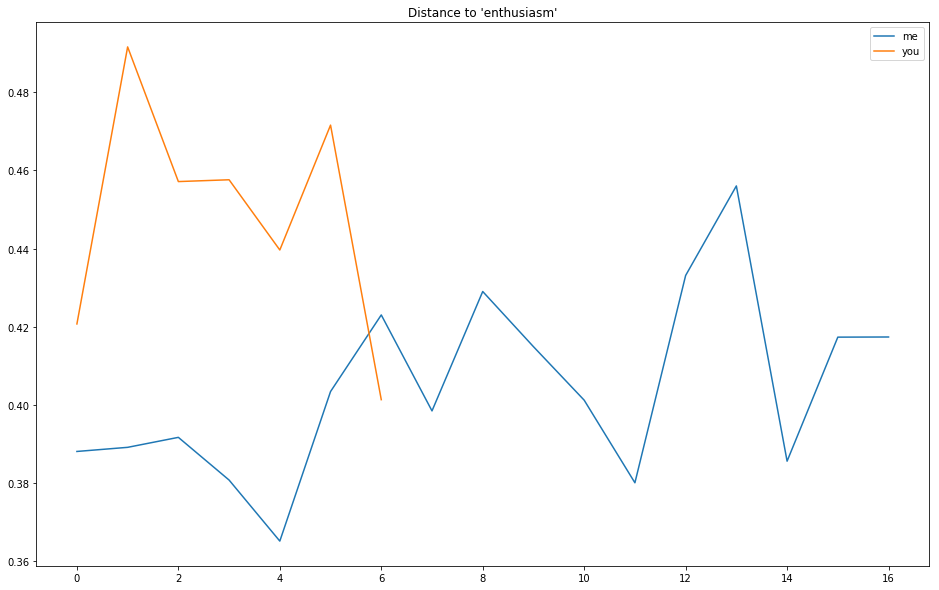

In [538]:
plot_trajs(toks, 'enthusiasm', ['me','you',''])
plt.show()

In [ ]:
df[(df.t1 == 'mourning') & (df.t0.isin(['Agatha','Tittens']))]

In [382]:
len(toks)

2900

In [433]:
from sys import getsizeof
locs = pd.DataFrame({(k, getsizeof(v)) for k,v in locals().items()})

In [434]:
locs.sort_values(by=1,ascending=False)

,0,1
561,S,13582584
153,D,13582584
154,S_flat,13582568
400,dist,13582568
395,most_similars_i_ravelled,13582568
192,highest_i,7104656
229,dist_plus,6796544
468,highest_i_flat,3552368
348,S_highest,3552368
311,excluded,2936031


In [431]:
del most_similars_i

In [435]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (24 entries)


In [443]:
len(toks)

2536

array([['FRANKENSTEIN', ':', 0.6760685126881693],
       ['FRANKENSTEIN', 'OR', 0.6589957725126112],
       ['FRANKENSTEIN', ',', 0.6658738539590416],
       ...,
       ['rugged', 'bosoms', 0.7851317693717147],
       ['rugged', '.', 0.5234263663546631],
       ['bosoms', '.', 0.5112680354180262]], dtype=object)

In [610]:
toks_unique = np.unique(toks_str)
toks_selected = np.unique(toks_str[highest_i][0,:])
m = len(toks_selected)
e = [(toks_selected[i],toks_selected[j]) for i in range(m) for j in range(i,m)]

In [611]:
import networkx as nx
from networkx.algorithms import community as nxcom

G = nx.Graph()
G.add_nodes_from(toks_unique)
G.add_edges_from(e)
print(nx.number_of_nodes(G), 'nodes')
print(nx.number_of_edges(G), 'edges')

934 nodes
432915 edges


In [619]:
#nx.get_edge_attributes(G,'weight')
comms = list(nxcom.asyn_lpa_communities(G))#, weight='weight'))#, weight='weight'))


In [620]:
set(len(c) for c in comms)

{1, 930}

In [625]:
import networkx.drawing.nx_pylab as nxd
nxd.draw_circular(G)

C:\Users\kevin\AppData\Roaming\Python\Python36\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Error in callback <function flush_figures at 0x00000170BC7451E0> (for post_execute):


KeyboardInterrupt: 